In [3]:
import argparse
import copy
import datetime
from fieldinfo import readcm, readNCLcm
import logging
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from importlib import reload

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import numpy as np
import os
import pandas as pd
import pdb
import pickle
import sklearn
from sklearn.model_selection import KFold
from scipy import spatial # for KDTree
import seaborn as sns
from tensorflow.keras.models import load_model
import visualizecv
import xarray
import yaml

from ml_functions import (
    assertclose,
    brier_skill_score,
    configs_match,
    get_argparser,
    get_features,
    load_df,
    rptdist2bool,
    get_savedmodel_path,
)

logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

2024-09-20 11:25:43.357489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 11:25:44.373722: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


ModuleNotFoundError: No module named 'visualizecv'

In [4]:
test = readNCLcm('MPL_Greys')[50::] + [[1,1,1]] + readNCLcm('MPL_Reds')[20::]
cmap = ListedColormap(test)
plot_thresh = 0.05
norm = BoundaryNorm(np.arange(0,plot_thresh*15,plot_thresh), ncolors=cmap.N, clip=True)


def get_ax():

    fig, plt.figure()
    proj = ccrs.LambertConformal(central_longitude=-101,central_latitude=38.33643,standard_parallels=(32,46))
    (llx, lly, llz), (urx, ury, urz) = proj.transform_points(
            cartopy.crs.PlateCarree(), 
            np.array([ll_lon, ur_lon]), 
            np.array([ll_lat, ur_lat])
            )
    # y/x aspect ratio was an attribute of Basemap object, but not cartopy.
    aspect = (ury - lly) / (urx - llx)

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

    fig.set_size_inches(12,12*aspect)
    ax = plt.axes(projection=proj)
    for i in ax.spines.items(): i[1].set_linewidth(0.5)

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.3)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.3)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='k', linewidth=0.25, facecolor='k', alpha=0.1)
    domains = { 'CONUS' : [-120.81058,-75.4,23.159264,49.4],
                'SGP'   : [-109,-86,25.5,38],
                'NGP'   : [-108,-86,40,49.80],
                'CGP'   : [-108.50,-86.60,33,45],
                'NW'    : [-124,-102.1,39,49],
                'SW'    : [-122,-101,31,42],
                'SE'    : [-96,-77,26.75,37],
                'NE'    : [-92,-69,39,47.5],
                'MATL'  : [-92,-72,33.5,41.50] }

    ax.set_extent(domains["CONUS"])
    return ax

In [5]:
def get_scores(args):
    savedmodel = get_savedmodel_path(args)
    ifile = f"{savedmodel}.{args.kfold}fold."
    #ifile += f"{args.teststart.strftime('%Y%m%d%H')}-{args.testend.strftime('%Y%m%d%H')}"
    ifile += "daily.scores.txt"
    if not os.path.exists(ifile):
        logging.error(f"{ifile} does not exist. Return empty DataFrame")
        return pd.DataFrame()
    scores = pd.read_csv(ifile, header=0, dtype=dict(forecast_hour=str))
    scores = scores[(scores.fit == "ensmean") & (scores.forecast_hour == "all")] # & (scores["class"] == "torn_rptdist_2hr")]
    scores["new"] = scores["bss"] + scores["auc"] + scores["aps"]
    scores = scores.set_index("init_time")
    return scores

In [5]:
parser = get_argparser()
args, argv = parser.parse_known_args()
args.batchnorm = True
args.model = 'NSC3km-12sec'
args.epochs = 10
args.debug = False
args.kfold = 1
args.learning_rate = 0.01
args.neurons = [1024,1024]
args.optimizer = 'SGD'
args.savedmodel = "nn/orphan_score_files/NSC3km-12sec.with_storm_mode.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0"
args.suite = "with_storm_mode"
args.teststart = pd.to_datetime("19000101") # omit UTC=True. It messes up comparisons later with tz-naive datetimes.
args.testend = pd.to_datetime("20220101") # omit UTC=True. It messes up comparisons later with tz-naive datetimes.

In [6]:
df = load_df(args, idir="work_sobash/NSC_objects")
df

2023-03-05 10:08:12,973 load NSC3km-12sec predictors from parquet file NSC3km-12sec.par
2023-03-05 10:08:12,978 reading NSC3km-12sec.par 19.3G


initialization_time  forecast_hour  UP_HELI_MAX  \
valid_time          y  x                                                     
2010-10-24 01:00:00 21 33  2010-10-24 00:00:00              1     0.067978   
                       34  2010-10-24 00:00:00              1     0.314260   
                       35  2010-10-24 00:00:00              1     1.025714   
                       36  2010-10-24 00:00:00              1     0.583827   
                    22 29  2010-10-24 00:00:00              1     0.027814   
...                                        ...            ...          ...   
2019-06-01 12:00:00 79 41  2019-05-31 00:00:00             36     0.000000   
                       42  2019-05-31 00:00:00             36     0.093916   
                       43  2019-05-31 00:00:00             36     0.007570   
                       44  2019-05-31 00:00:00             36     0.018947   
                    80 41  2019-05-31 00:00:00             36     0.000000   

                           UP_HELI_MAX03  UP_HELI_MAX01  UP_HELI_MIN  \
valid_time          y  x                                               
2010-10-24 01:00:00 21 33       0.296034       0.196612    -0.010770   
                       34       0.176270       0.127414    -0.007257   
                       35       1.020050       0.180848    -0.025469   
                       36       0.656277       0.093678    -0.021125   
                    22 29       0.007018       0.016367    -0.048672   
...                                  ...            ...          ...   
2019-06-01 12:00:00 79 41       0.002419       0.003778    -0.005988   
                       42       0.002634       0.016581    -0.018262   
                       43       0.003313       0.006854    -0.002156   
                       44       0.005924       0.005680    -0.003239   
                    80 41       0.001321       0.004331    -0.004681   

                           W_UP_MAX  W_DN_MAX  WSPD10MAX           STP  ...  \
valid_time          y  x                                                ...   
2010-10-24 01:00:00 21 33  0.987273 -1.086382  13.333640  1.625479e-03  ...   
                       34  1.235950 -1.166640  12.562189  7.290076e-03  ...   
                       35  2.022542 -2.053045  14.865541  4.212065e-02  ...   
                       36  1.759294 -1.781828  16.467278  7.042569e-02  ...   
                    22 29  0.779032 -1.174967   7.928312  1.427625e-08  ...   
...                             ...       ...        ...           ...  ...   
2019-06-01 12:00:00 79 41  0.197930 -0.284146   2.709627  0.000000e+00  ...   
                       42  1.284478 -1.181286   6.881397  0.000000e+00  ...   
                       43  0.203314 -0.404291   4.954895  0.000000e+00  ...   
                       44  0.336655 -0.336549   5.181412  7.027958e-07  ...   
                    80 41  0.179655 -0.155095   2.517964  0.000000e+00  ...   

                           Local_Solar_Hour_cos  cg_40km_1hr  ic_40km_1hr  \
valid_time          y  x                                                    
2010-10-24 01:00:00 21 33             -0.317067          NaN          NaN   
                       34             -0.320235          NaN          NaN   
                       35             -0.323442          NaN          NaN   
                       36             -0.326688          NaN          NaN   
                    22 29             -0.290249          NaN          NaN   
...                                         ...          ...          ...   
2019-06-01 12:00:00 79 41             -0.363437          NaN          NaN   
                       42             -0.366493          NaN          NaN   
                       43             -0.369589          NaN          NaN   
                       44             -0.372725          NaN          NaN   
                    80 41             -0.378816          NaN          NaN   

                           cg_40km_2hr  ic_40

In [17]:
df, label_cols = rptdist2bool(df, args)
df

2023-03-05 10:26:29,910 using [0, 1, 2] time windows for lsrtypes until Ryan updates them with [1,2,4]
2023-03-05 10:26:29,910 rename columns {'sighail_rptdist_0hr': 'sighail_40km_0hr', 'sighail_rptdist_1hr': 'sighail_40km_1hr', 'sighail_rptdist_2hr': 'sighail_40km_2hr', 'sigwind_rptdist_0hr': 'sigwind_40km_0hr', 'sigwind_rptdist_1hr': 'sigwind_40km_1hr', 'sigwind_rptdist_2hr': 'sigwind_40km_2hr', 'hailone_rptdist_0hr': 'hailone_40km_0hr', 'hailone_rptdist_1hr': 'hailone_40km_1hr', 'hailone_rptdist_2hr': 'hailone_40km_2hr', 'wind_rptdist_0hr': 'wind_40km_0hr', 'wind_rptdist_1hr': 'wind_40km_1hr', 'wind_rptdist_2hr': 'wind_40km_2hr', 'torn_rptdist_0hr': 'torn_40km_0hr', 'torn_rptdist_1hr': 'torn_40km_1hr', 'torn_rptdist_2hr': 'torn_40km_2hr'}
2023-03-05 10:26:29,912 Convert severe report distance to boolean [0,40km) = True
2023-03-05 10:26:44,305 threshold wbug at 10 flashes
2023-03-05 10:27:57,365 cg_40km_1hr or ic_40km_1hr = cg.ic_40km_1hr
2023-03-05 10:28:35,840 threshold wbug at 10 

initialization_time  forecast_hour  UP_HELI_MAX  \
valid_time          y  x                                                     
2010-10-24 01:00:00 21 33  2010-10-24 00:00:00              1     0.067978   
                       34  2010-10-24 00:00:00              1     0.314260   
                       35  2010-10-24 00:00:00              1     1.025714   
                       36  2010-10-24 00:00:00              1     0.583827   
                    22 29  2010-10-24 00:00:00              1     0.027814   
...                                        ...            ...          ...   
2019-06-01 12:00:00 79 41  2019-05-31 00:00:00             36     0.000000   
                       42  2019-05-31 00:00:00             36     0.093916   
                       43  2019-05-31 00:00:00             36     0.007570   
                       44  2019-05-31 00:00:00             36     0.018947   
                    80 41  2019-05-31 00:00:00             36     0.000000   

                           UP_HELI_MAX03  UP_HELI_MAX01  UP_HELI_MIN  \
valid_time          y  x                                               
2010-10-24 01:00:00 21 33       0.296034       0.196612    -0.010770   
                       34       0.176270       0.127414    -0.007257   
                       35       1.020050       0.180848    -0.025469   
                       36       0.656277       0.093678    -0.021125   
                    22 29       0.007018       0.016367    -0.048672   
...                                  ...            ...          ...   
2019-06-01 12:00:00 79 41       0.002419       0.003778    -0.005988   
                       42       0.002634       0.016581    -0.018262   
                       43       0.003313       0.006854    -0.002156   
                       44       0.005924       0.005680    -0.003239   
                    80 41       0.001321       0.004331    -0.004681   

                           W_UP_MAX  W_DN_MAX  WSPD10MAX           STP  ...  \
valid_time          y  x                                                ...   
2010-10-24 01:00:00 21 33  0.987273 -1.086382  13.333640  1.625479e-03  ...   
                       34  1.235950 -1.166640  12.562189  7.290076e-03  ...   
                       35  2.022542 -2.053045  14.865541  4.212065e-02  ...   
                       36  1.759294 -1.781828  16.467278  7.042569e-02  ...   
                    22 29  0.779032 -1.174967   7.928312  1.427625e-08  ...   
...                             ...       ...        ...           ...  ...   
2019-06-01 12:00:00 79 41  0.197930 -0.284146   2.709627  0.000000e+00  ...   
                       42  1.284478 -1.181286   6.881397  0.000000e+00  ...   
                       43  0.203314 -0.404291   4.954895  0.000000e+00  ...   
                       44  0.336655 -0.336549   5.181412  7.027958e-07  ...   
                    80 41  0.179655 -0.155095   2.517964  0.000000e+00  ...   

                           ic_40km_4hr  flashes_40km_1hr  flashes_40km_2hr  \
valid_time          y  x                                                     
2010-10-24 01:00:00 21 33        False             False             False   
                       34        False             False             False   
                       35        False             False             False   
                       36        False             False             False   
                    22 29        False             False             False   
...                                ...               ...               ...   
2019-06-01 12:00:00 79 41        False             False             False   
                       42        False             False             False   
                       43        False             False             False   
                       44        False             False             False   
                    80 41        False             False             False   

                           flash

In [18]:
df[label_cols].sum()

sighail_40km_0hr      3355
sighail_40km_1hr      9069
sighail_40km_2hr     14731
sigwind_40km_0hr      4739
sigwind_40km_1hr     13198
sigwind_40km_2hr     21544
hailone_40km_0hr     27743
hailone_40km_1hr     68761
hailone_40km_2hr    108395
wind_40km_0hr        46242
wind_40km_1hr       117157
wind_40km_2hr       186426
torn_40km_0hr         6611
torn_40km_1hr        17379
torn_40km_2hr        27973
any_40km_0hr         70411
any_40km_1hr        170486
any_40km_2hr        266879
cg_40km_1hr         460186
ic_40km_1hr         536014
cg.ic_40km_1hr      547602
flashes_40km_1hr    187680
cg_40km_2hr         402091
ic_40km_2hr         480678
cg.ic_40km_2hr      489041
flashes_40km_2hr    256225
cg_40km_4hr         270597
ic_40km_4hr         351431
cg.ic_40km_4hr      355393
flashes_40km_4hr    370526
dtype: int64

In [19]:
args0 = copy.deepcopy(args)
args0.suite = "default"
args0.savedmodel = "nn/orphan_score_files/NSC3km-12sec.default.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0"

df = df[get_features(args)]
df0 = df[get_features(args0)]

In [20]:
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, event=None, fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=10, folds=None, glm=True, kfold=1, idate=None, ifile=None, learning_rate=0.01, model='NSC3km-12sec', neurons=[1024, 1024], nfits=5, nprocs=0, optimizer='SGD', reg_penalty=0.01, rptdist=40, savedmodel='nn/orphan_score_files/NSC3km-12sec.with_storm_mode.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0', seed=None, trainend=None, trainstart=None, testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('1900-01-01 00:00:00'), suite='with_storm_mode', twin=[1, 2, 4])

In [21]:
args0

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, event=None, fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=10, folds=None, glm=True, kfold=1, idate=None, ifile=None, learning_rate=0.01, model='NSC3km-12sec', neurons=[1024, 1024], nfits=5, nprocs=0, optimizer='SGD', reg_penalty=0.01, rptdist=40, savedmodel='nn/orphan_score_files/NSC3km-12sec.default.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0', seed=None, trainend=None, trainstart=None, testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('1900-01-01 00:00:00'), suite='default', twin=[1, 2, 4])

In [25]:
scores = get_scores(args)
scores0 = get_scores(args0)
scores0

,class,fit,fold,forecast_hour,bss,base_rate,auc,aps,new
init_time,,,,,,,,,
2016-07-04 00:00:00,sighail_40km_2hr,ensmean,all,all,0.003723,0.000321,0.956647,0.010334,0.970704
2016-07-04 00:00:00,sigwind_40km_2hr,ensmean,all,all,0.005563,0.001156,0.930832,0.013870,0.950265
2016-07-04 00:00:00,hailone_40km_2hr,ensmean,all,all,-0.014866,0.001605,0.909799,0.022702,0.917635
2016-07-04 00:00:00,wind_40km_2hr,ensmean,all,all,0.068241,0.009919,0.931444,0.131306,1.130990
2016-07-04 00:00:00,torn_40km_2hr,ensmean,all,all,0.007902,0.000674,0.945369,0.016577,0.969848
...,...,...,...,...,...,...,...,...,...
2019-05-20 00:00:00,sigwind_40km_2hr,ensmean,all,all,-0.000720,0.000642,0.992142,0.042886,1.034307
2019-05-20 00:00:00,hailone_40km_2hr,ensmean,all,all,0.095493,0.005265,0.979198,0.157478,1.232169
2019-05-20 00:00:00,wind_40km_2hr,ensmean,all,all,0.069267,0.006260,0.973217,0.176205,1.218689


In [ ]:
get_savedmodel_path(args)

'nn/orphan_score_files/NSC3km-12sec.with_storm_mode.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0'

In [24]:
get_savedmodel_path(args0)

'nn/orphan_score_files/NSC3km-12sec.default.rpt_40km_2hr.1024n1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.01.dr0.0'

In [30]:
xx = pd.concat([scores,scores0], keys=["mode","default"],names=["suite","initialization_time"])
xx

class      fit fold forecast_hour  \
suite   initialization_time                                                 
mode    2016-07-04 00:00:00  sighail_40km_2hr  ensmean  all           all   
        2016-07-04 00:00:00  sigwind_40km_2hr  ensmean  all           all   
        2016-07-04 00:00:00  hailone_40km_2hr  ensmean  all           all   
        2016-07-04 00:00:00     wind_40km_2hr  ensmean  all           all   
        2016-07-04 00:00:00     torn_40km_2hr  ensmean  all           all   
...                                       ...      ...  ...           ...   
default 2019-05-20 00:00:00  sigwind_40km_2hr  ensmean  all           all   
        2019-05-20 00:00:00  hailone_40km_2hr  ensmean  all           all   
        2019-05-20 00:00:00     wind_40km_2hr  ensmean  all           all   
        2019-05-20 00:00:00     torn_40km_2hr  ensmean  all           all   
        2019-05-20 00:00:00      any_40km_2hr  ensmean  all           all   

                                  bss  base_rate       auc       aps       new  
suite   initialization_time                                                     
mode    2016-07-04 00:00:00  0.003497   0.000321  0.955835  0.009540  0.968871  
        2016-07-04 00:00:00  0.005463   0.001156  0.932116  0.013459  0.951038  
        2016-07-04 00:00:00 -0.016206   0.001605  0.911464  0.021925  0.917183  
        2016-07-04 00:00:00  0.068786   0.009919  0.931585  0.130357  1.130728  
        2016-07-04 00:00:00  0.009184   0.000674  0.945805  0.020053  0.975043  
...                               ...        ...       ...       ...       ...  
default 2019-05-20 00:00:00 -0.000720   0.000642  0.992142  0.042886  1.034307  
        2019-05-20 00:00:00  0.095493   0.005265  0.979198  0.157478  1.232169  
        2019-05-20 00:00:00  0.069267   0.006260  0.973217  0.176205  1.218689  
        2019-05-20 00:00:00  0.070375   0.002568  0.983580  0.114992  1.168946  
        2019-05-20 00:00:00  0.180491   0.010657  0.977847  0.312491  1.470829  

[2724 rows x 9 columns]

2023-03-05 11:24:00,199 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-05 11:24:00,223 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


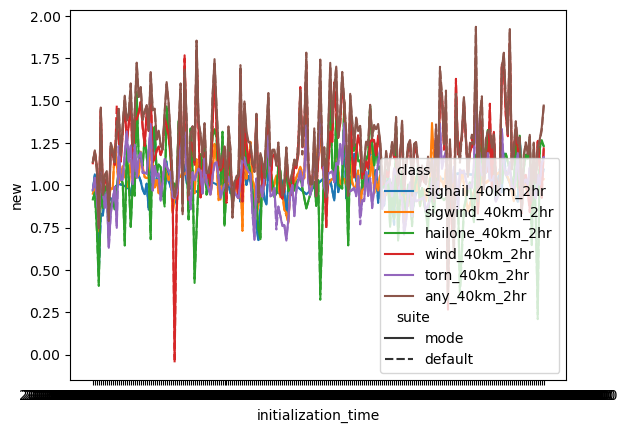

In [32]:
if not xx.empty:
    plt.clf()
    ax = sns.lineplot(data=xx.reset_index(),x="initialization_time",y="new",style="suite",hue="class")
    plt.show()

**Change idate, class_label, and event_type**

In [37]:
assert idate in df0.index.get_level_values("initialization_time"), f"idate {idate} not in DataFrame"
class_label, event_type = "flashes_40km_2hr", "flashes_40km_2hr"

import spc

assert event_type in ["any", "flashes_40km_2hr", "hail", "high wind", "large hail", "torn", "wind"]

start = idate + datetime.timedelta(hours=min(fhrs))
end = idate + datetime.timedelta(hours=max(fhrs))
start = start.tz_localize('UTC')
end = end.tz_localize('UTC')
allrpts = spc.get_storm_reports(start=start, end=end, RyanSobashSanityCheck=True)

tmp, dbname = spc.RyanSobash(start=start, end=end)

lonlat = df0[["lon","lat"]].groupby(["y","x"]).first().values
lon, lat = lonlat[:,0], lonlat[:,1]
tree = spatial.KDTree(lonlat) # don't get lon and lat from bad. they may not be in predictor suite
rpts = allrpts if event_type == "any" else allrpts[(allrpts["event_type"] == event_type)]
distances, closest = tree.query(rpts[["slon","slat"]])
closest = np.unique(closest)

if event_type.startswith("flashes"):
    closest = df[event_type] > args.flash
    closest = closest.groupby(["y","x"]).max()

NameError: name 'idate' is not defined

In [4]:
import ml_functions
reload(ml_functions)

<module 'ml_functions' from '/glade/u/home/ahijevyc/ml_functions.py'>

In [16]:
def predict(args, df):
    savedmodel = savedmodel_default(args, fhr_str='f01-f48')
    logging.info(f"savedmodel {savedmodel}")
    df, labels = rptdist2bool(df, args)
    logging.debug(f"{len(labels)} labels {labels}")
    df = df[get_features(args)]

    #df = df.xs(idate, level="initialization_time")
    features_max = df.groupby(["y","x"]).max()

    y_preds = pd.DataFrame()
    for thisfit in range(args.nfits):
        print(thisfit, end=' ')
        savedmodel_thisfit = f"nn/nn_{savedmodel}_{thisfit}/{args.kfold}fold0"
        yl = yaml.load(open(os.path.join(savedmodel_thisfit, "config.yaml"), "r"), Loader=yaml.Loader)
        yl_labels = yl["labels"]
        del(yl["labels"])
        assert configs_match(yl["args"], args), f"this config {args} don't match yaml {yl['args']}"
        del(yl["args"])
        assert yl_labels == labels, f"yaml labels {yl_labels} don't match current labels {labels}"
        # TODO: make sure these test cases were not used to train model
        sv = pd.DataFrame(yl).set_index("columns").T
        norm_features = (df - sv.loc["mean"]) / sv.loc["std"]
        nnmodel = load_model(savedmodel_thisfit)
        Y = nnmodel.predict(norm_features.to_numpy(dtype="float32"), batch_size=1298*12)
        Y = pd.DataFrame(Y, columns=labels, index=df.index)
        Y = pd.concat([Y], keys=[thisfit], names=["fit"])
        y_preds = y_preds.append(Y)

    levels_nofit = list(set(y_preds.index.names) - set(["fit"]))
    ensmean = y_preds.groupby(levels_nofit).mean() # mean of fits
    ensmean_max = ensmean.groupby(["y","x","initialization_time"]).max() # max of fhrs
    return savedmodel, features_max, ensmean, ensmean_max

In [17]:
df.index.get_level_values("valid_time").hour

Int64Index([23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
            ...
             1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
           dtype='int64', name='valid_time', length=3924)

0 - 3139 train 785 test
1 - 3139 train 785 test


False    3237
True      687
Name: flashes_40km_2hr, dtype: int64


2 - 3139 train 785 test
3 - 3139 train 785 test
4 - 3140 train 784 test


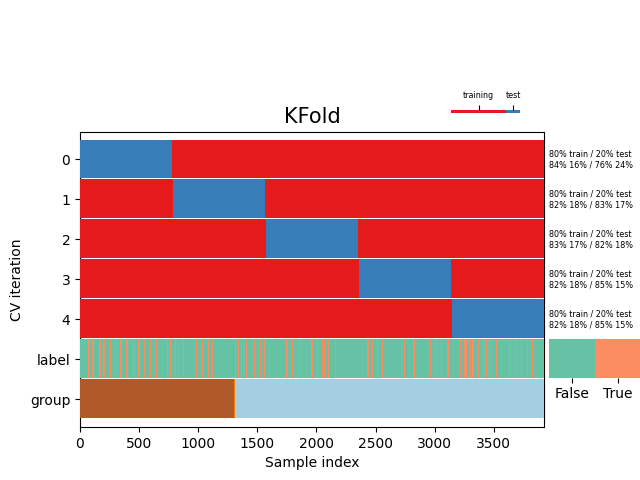

In [18]:
if args.kfold > 1:
    cv = KFold(n_splits=args.kfold) 
    # labels has no effect for KFold, but for GroupKFold, it, along with groups argument would affect folds.
    labels = df[event_type] >= args.flash
    labels = labels[::1]
    print(labels.value_counts())
    X = labels
    cvsplit = cv.split(X, labels) 
    plot_splits= True
    if plot_splits:
        fig, ax = plt.subplots()
        plt.subplots_adjust(right=0.85)
        y = labels
        visualizecv.plot_cv_indices(cv, X, y, df.index.get_level_values("valid_time").hour, ax)
else:
    # Use everything for training. train_split is every index; test_split is empty
    cvsplit = [(np.arange(len(df)), [])]



In [19]:
savedmodel0, features_max0, ensmean0, ensmean_max0 = predict(args0, df0) #.xs(idate, level="initialization_time"))
savedmodel, features_max, ensmean, ensmean_max = predict(args, df) #.xs(idate, level="initialization_time"))

savedmodel HRRR.default.10flash.rpt_40km_2hr.16n.ep10.f01-f48.bs1024.2layer.Adam.L20.01.lr0.001.dr0.0.bn


0 

2023-01-04 16:14:19.862113: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-04 16:14:19.874832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc53): /proc/driver/nvidia/version does not exist
2023-01-04 16:14:19.905493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 16:14:20.793388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1 2 3 4 WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ac5bfb6ca70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ac5bfb6ca70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
savedmodel HRRR.default.10flash.rpt_40km_2hr.16n.ep10.f01-f48.bs1024.2layer.Adam.L20.01.lr0.001.dr0.0.bn


0 WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ac5c66de680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x2ac5c66de680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1 2 3 4 

In [20]:
def derive_tscore(y_pred, labels):
    bss = brier_skill_score(labels, y_pred)
    base_rate = labels.mean()
    auc = sklearn.metrics.roc_auc_score(
        labels, y_pred) if labels.any() else np.nan
    aps = sklearn.metrics.average_precision_score(
        labels, y_pred)
    tscores = pd.DataFrame(dict(bss=bss,base_rate=base_rate,auc=auc,aps=aps,n=len(labels)),index=[idate])
    return tscores
if scores.empty:
    tscores  = derive_tscore(ensmean[class_label], labels)
    tscores0 = derive_tscore(ensmean0[class_label], labels)
else:
    tscores = scores[scores["class"] == class_label]
    tscores0 = scores0[scores0["class"] == class_label]

In [21]:
labels

valid_time           y   x   initialization_time
2020-07-08 23:00:00  48  12  2020-07-08             False
                     49  12  2020-07-08             False
                     69  12  2020-07-08              True
                     70  12  2020-07-08              True
                     47  13  2020-07-08             False
                                                    ...  
2020-07-09 01:00:00  25  46  2020-07-08             False
                     26  46  2020-07-08             False
                     27  46  2020-07-08             False
                     28  46  2020-07-08             False
                     29  46  2020-07-08             False
Name: flashes_40km_2hr, Length: 3924, dtype: bool

In [22]:
features_max0.equals(features_max)

True

In [23]:
savedmodel0, savedmodel

('HRRR.default.10flash.rpt_40km_2hr.16n.ep10.f01-f48.bs1024.2layer.Adam.L20.01.lr0.001.dr0.0.bn',
 'HRRR.default.10flash.rpt_40km_2hr.16n.ep10.f01-f48.bs1024.2layer.Adam.L20.01.lr0.001.dr0.0.bn')

# Highest supercell probability

In [24]:
(features_max["DNN_1_Supercell_nprob"] + features_max["CNN_1_Supercell_nprob"]).groupby("initialization_time").max().sort_values(ascending=False)

KeyError: 'DNN_1_Supercell_nprob'

While tornado probability *is* positively correlated with supercells ...

# Greatest probability difference

In [ ]:
((ensmean - ensmean0)**2).groupby("initialization_time").mean().sum(axis=1).sort_values(ascending=False).head(10)

# Best combined stat improvement

In [ ]:
ww = (scores.reset_index().set_index(["init_time","class"])[["bss","auc","aps"]] - scores0.reset_index().set_index(["init_time","class"])[["bss","auc","aps"]])
ww["new"] = ww["bss"] + ww["auc"] + ww["aps"]
ww.sort_values("new", ascending=False).head(20)

In [ ]:
scores.reset_index().set_index(["init_time","class"])

In [ ]:
df0.shape

In [ ]:
# Combine feature and predictions DataFrames
adf0 = pd.concat([df0, ensmean0], axis="columns")
adf = pd.concat([df0, ensmean], axis="columns")

In [ ]:
hi_S = adf["DNN_1_Supercell_nprob"] >= 0.001
QLCS_groups = pd.cut(adf.loc[hi_S,"DNN_1_QLCS_nprob"], np.arange(0, 1.25, .25))

In [ ]:
# Mean features and predictions as function of probability of QLCS (0-25%, 25-50%, 50-75%, 75-100%)
adf.loc[hi_S].groupby(QLCS_groups).mean().iloc[:,18:]

### class_label was set earlier above

In [ ]:
ensmean_max[class_label]

In [ ]:
fields = [ensmean_max[class_label]]
for f in ["DNN_1_Supercell_nprob", "DNN_1_QLCS_nprob", "DNN_1_Disorganized_nprob"]:
    if f in features_max:
        fields.append(features_max[f].xs(idate, level="initialization_time"))
    
for field in fields:
    ax = get_ax()
    ax.set_title(f"{start}+{end-start}   {savedmodel}\n{field.name}", fontsize="xx-small")
    ax.text(0,0,f'{tscores.loc[idate]}', transform=ax.transAxes, ha="left", va="bottom")

    if not allrpts.empty and "flash" not in class_label:
        legend_items = spc.plot(allrpts, ax, scale=2)
        ax.legend(handles=legend_items.values(), fontsize='xx-small')

    
    ax.scatter(lon[closest], lat[closest], color="black", marker="o", s=100, lw=0.75, facecolors='0.7', edgecolors='k', transform=ccrs.PlateCarree())
    
    for i, b in enumerate(field):
        color = cmap(norm([b])[0])
        if not np.isnan(b) and not np.isinf(b) and b>plot_thresh:
            val = round(b*100)
            a = ax.text(lon[i], lat[i], val, fontsize=8, ha="center", va="center", family="monospace", 
                        color = color, fontweight="bold", transform=ccrs.PlateCarree())

In [ ]:
field = (ensmean_max - ensmean_max0)[class_label].xs(idate, level="initialization_time")
ax = get_ax()
ax.set_title(f"{savedmodel}-{savedmodel0}", fontsize="xx-small")
ax.text(0,0,f'{tscores.loc[idate]}', transform=ax.transAxes, ha="left", va="bottom")
ax.text(1,0,f'{tscores0.loc[idate]}', transform=ax.transAxes, ha="right", va="bottom")

if not rpts.empty:
    legend_items = spc.plot(rpts, ax, scale=2)
    ax.legend(handles=legend_items.values(), fontsize='xx-small')

ax.scatter(lon[closest], lat[closest], color="black", marker="o", s=100, lw=0.75, facecolors='0.7', edgecolors='k', transform=ccrs.PlateCarree())
cmap = plt.get_cmap("PiYG")
norm = BoundaryNorm(np.arange(-0.03,0.03,0.003), ncolors=cmap.N, clip=True)

for i, b in enumerate(field):
    color = cmap(norm([b])[0])
    if not np.isnan(b) and not np.isinf(b) and abs(b)>0.002:
        val = round(b*100)
        a = ax.text(lon[i], lat[i], val, fontsize=8, ha="center", va="center", family="monospace", 
                    color = color, fontweight="bold", transform=ccrs.PlateCarree())

In [ ]:
rpts

In [ ]:
levels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
refl_colors = readcm('/glade/u/home/sobash/RT2015_gpx/cmap_rad.rgb')[:14]
cmap = ListedColormap(refl_colors)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

paths = f'/glade/p/mmm/parc/sobash/NSC/3KM_WRF_POST_12sec_ts/{start:%Y%m%d00}/diags_d01_*.nc'
fh = xarray.open_mfdataset(paths, concat_dim="Time", combine="nested", data_vars=["REFL_COM"])
for itime in [12,18,24,27,30,33]:
    ax = get_ax()
    cref = fh['REFL_COM'].isel(Time=itime)
    img = ax.imshow(cref.values, origin="lower", cmap=cmap, norm=norm, extent=(-2071901.9869298763, 2663144.2246847088,-1465111.2368046804, 1489182.3023281314))
    plt.colorbar(img, shrink=0.8)
    ax.set_title(fh.Times.isel(Time=itime).load().data)